In [1]:
import Pkg; 

if split(pwd(),"/")[end] == "random_walk"
    cd(joinpath(@__DIR__, "../../../"))
    Pkg.activate("Project.toml")
end

using MorphoMol
using GLMakie
using LinearAlgebra
using Random
using Rotations
using StaticArrays
using Distributions
using Distances

  Activating project at `~/Doktor/Code/MorphoMol/MorphoMolNotebooks`


In [41]:
function solvation_free_energy_and_measures_in_bounds(x::Vector{Float64}, radii::Vector{Float64}, rs::Float64, prefactors::AbstractVector, overlap_jump::Float64, overlap_slope::Float64, bounds::Float64, delaunay_eps::Float64)
    if any(0.0 >= e || e >= bounds for e in x[1:3:end]) || any(0.0 >= e || e >= bounds for e in x[2:3:end]) || any(0.0 >= e || e >= bounds for e in x[3:3:end])
        return Inf, [Inf, Inf, Inf, Inf, Inf]
    end
    measures = MorphoMol.Energies.get_geometric_measures_and_overlap_value(x, 1, radii, rs, overlap_jump, overlap_slope, delaunay_eps)
    sum(measures .* [prefactors; 1.0]), Dict{String,Any}("Vs" => measures[1], "As" => measures[2], "Cs" => measures[3], "Xs" => measures[4], "OLs" => measures[5])
end

function solvation_free_energy_in_bounds(x::Vector{Float64}, radii::Vector{Float64}, rs::Float64, prefactors::AbstractVector, overlap_jump::Float64, overlap_slope::Float64, bounds::Float64, delaunay_eps::Float64)
    if any(0.0 >= e || e >= bounds for e in x[1:3:end]) || any(0.0 >= e || e >= bounds for e in x[2:3:end]) || any(0.0 >= e || e >= bounds for e in x[3:3:end])
        return Inf, [Inf, Inf, Inf, Inf, Inf]
    end
    measures = MorphoMol.Energies.get_geometric_measures_and_overlap_value(x, 1, radii, rs, overlap_jump, overlap_slope, delaunay_eps)
    sum(measures .* [prefactors; 1.0])
end

solvation_free_energy_in_bounds (generic function with 1 method)

In [155]:
mol_type = "6r7m"
template_centers = [0.0, 0.0, 0.0]
template_radii = [1.0]
n_mol = 4
bounds = 4.0
x_init = rand(n_mol * 3) .* bounds
#x_init = Vector{Float64}([1.0, 0.0, 0.0, 3.0, 0.0, 0.0])
n_atoms_per_mol = length(template_radii)
radii = vcat([template_radii for i in 1:n_mol]...);

In [156]:
perturb_all(x, Σ) = x .+ (randn(length(x)) .* Σ)

function perturb_single_randomly_chosen(x, σ_t)
    x_cand = deepcopy(x)
    i  = rand(0:(length(x)÷3)-1)
    x_cand[(i*3)+1:(i*3)+3] = x_cand[(i*3)+1:(i*3)+3] .+ (randn(3) .* σ_t)
    x_cand
end

perturb_single_randomly_chosen (generic function with 1 method)

In [201]:
T = 0.5
β = 1.0 / T

rs = 0.475
eta = 0.475
pf = MorphoMol.Energies.get_prefactors(rs, eta)
overlap_slope = 150.0
overlap_jump = 100.0
bounds = 4.0

σ_t = 0.25
Σ = vcat([[σ_t, σ_t, σ_t] for _ in 1:n_mol]...)


energy(x) = solvation_free_energy_and_measures_in_bounds(x, radii, rs, pf, 100.0, overlap_slope, bounds, 1.0)
#energy(x) = solvation_free_energy_in_bounds(x, radii, rs, pf, 0.0, overlap_slope, bounds, 1.0)
perturbation(x) = perturb_single_randomly_chosen(x, σ_t)

output = Dict{String, Vector}(
    "states" => Vector{Vector{Float64}}([]),
    "Es" => Vector{Float64}([]), 
    "Vs" => Vector{Float64}([]), 
    "As" => Vector{Float64}([]), 
    "Cs" => Vector{Float64}([]), 
    "Xs" => Vector{Float64}([]),
    "OLs" => Vector{Float64}([]),
    "αs" => Vector{Float32}([]),
)

rwm = MorphoMol.Algorithms.RandomWalkMetropolis(energy, perturbation, β)
simulation_time_minutes = 0.04
MorphoMol.Algorithms.simulate!(rwm, x_init, simulation_time_minutes, output);
output["αs"][end]

0.08188236f0

In [202]:
println("Initial energy: $(output["Es"][1]) | final energy: $(output["Es"][end]) | minimal energy: $(minimum(output["Es"]))")

Initial energy: 905.3749668504631 | final energy: 320.253430156267 | minimal energy: 315.0008993011494


In [203]:
try
    rm("assets/output", recursive = true)
catch 
end
mkpath("assets/output")
for (i, state) in enumerate(output["states"])
    MorphoMol.Utilities.state_to_poly(state, radii, "assets/output/$(i)", n_mol, n_atoms_per_mol)
end

In [204]:
function generate_ouput_plots(sim_out, pf, burn_in = 100)
    paired_colors = cgrad(:Paired_12, 12, categorical = true)
    xs = 1:length(sim_out["Vs"][burn_in:end])

    pt_per_in = 72
    width =  5*5
    height = 5*3
    f_size = (pt_per_in * width, pt_per_in * height)
    fs = 15
    border_width = 0.5
    fig = Figure(size = f_size, fontsize = fs)
    ms = 15
    scatter(fig[1, 1], xs, sim_out["Vs"][burn_in:end] .* pf[1], markersize = ms, color = paired_colors[1], axis = (ylabel = L"V", ylabelrotation = 0,))
    scatter(fig[1, 2], xs, sim_out["As"][burn_in:end] .* pf[2], markersize = ms, color = paired_colors[3], axis = (ylabel = L"A", ylabelrotation = 0,))
    scatter(fig[1, 3], xs, sim_out["Cs"][burn_in:end] .* pf[3], markersize = ms, color = paired_colors[5], axis = (ylabel = L"C", ylabelrotation = 0,))
    scatter(fig[1, 4], xs, sim_out["Xs"][burn_in:end] .* pf[4], markersize = ms, color = paired_colors[7], axis = (ylabel = L"X", ylabelrotation = 0,))
    scatter(fig[2, 1], xs, sim_out["OLs"][burn_in:end], markersize = ms, color = paired_colors[10], axis = (ylabel = L"OL", ylabelrotation = 0,))
    scatter(fig[2, 2], xs, sim_out["Es"][burn_in:end], markersize = ms, color = paired_colors[12], axis = (ylabel = L"F_{sol}", ylabelrotation = 0,))
    #save(string("$(save_dir)/hmc_output_plots.png"), fig, pt_per_unit = 1)
    fig
end

generate_ouput_plots (generic function with 3 methods)

In [205]:
argmin(output["Es"])

116

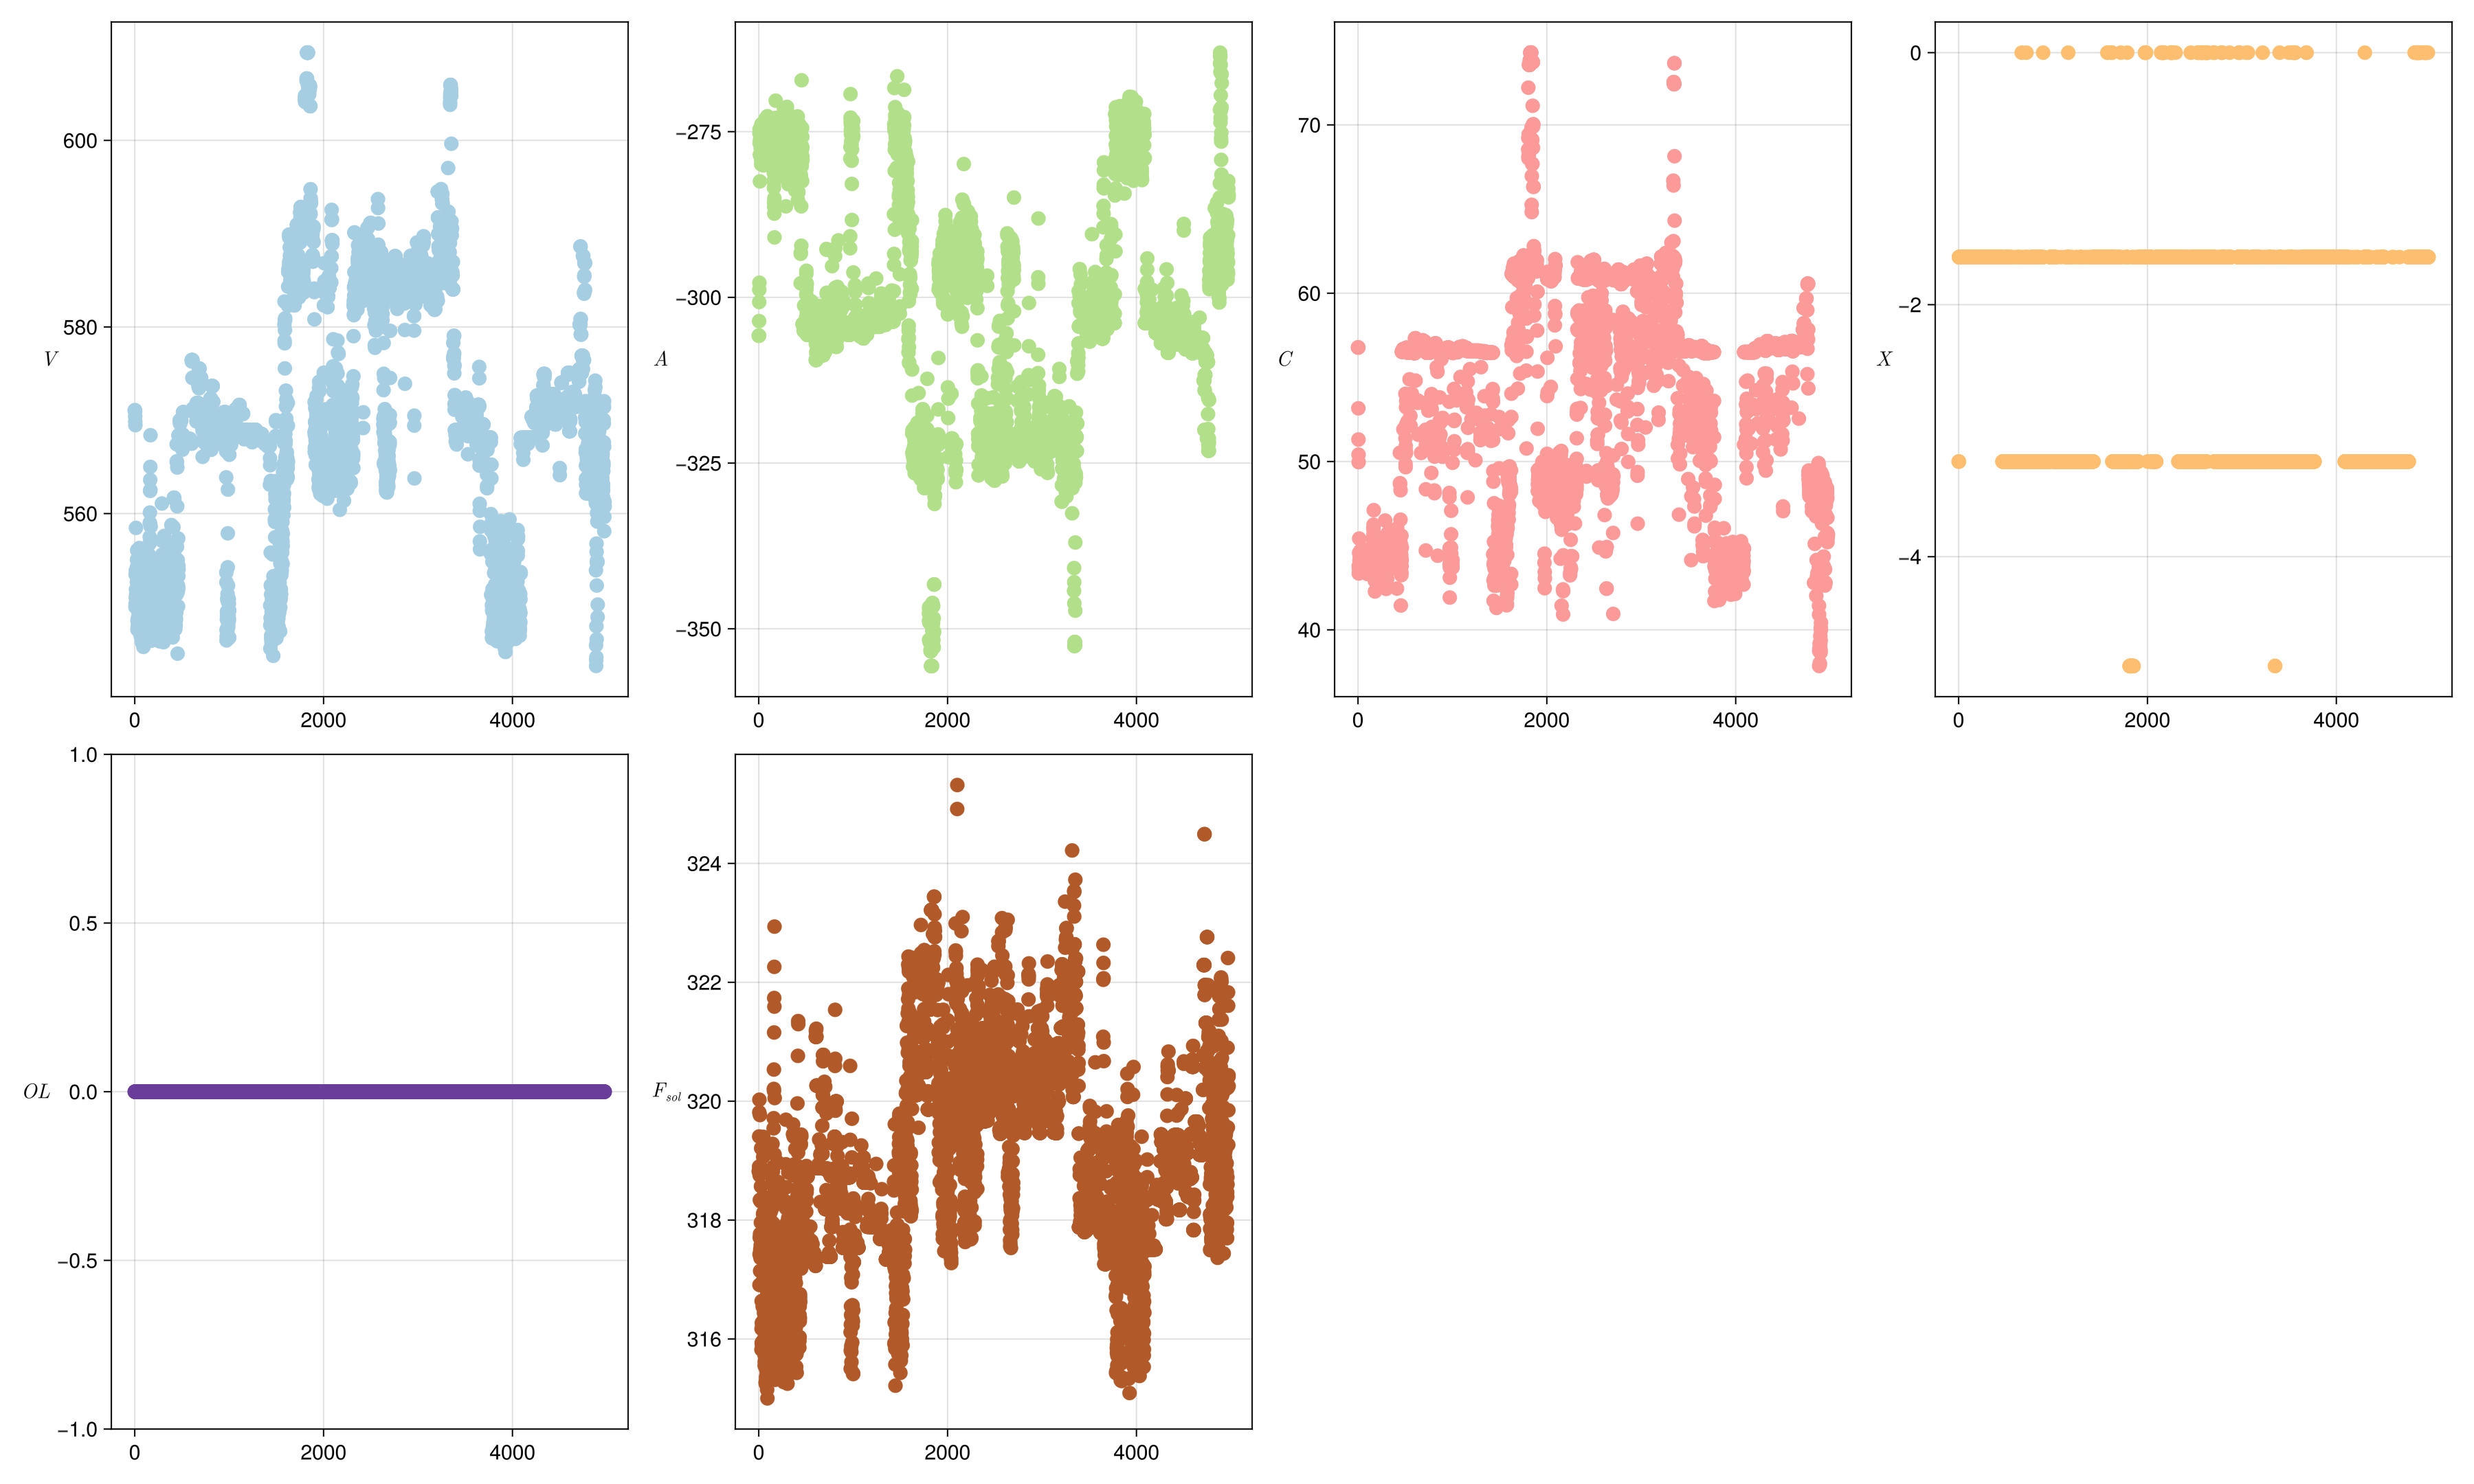

In [208]:
generate_ouput_plots(output, pf, 25)